<p style="text-align: center;"><font size="8"><b>Genetic Algorithms</b></font><br>

In many science and engineering applications we are interested in finding the best possible solution to a problem. This is called **optimization**. For example, we may want to find the shape of a wing the creates the most possible lift.

![airfoils](images/airfoils.png)


In the previous example, we are trying to **maximize** the possible lift. To do this we can change the shape of the wing. The wing shape may be specified by a number of control points. By varying these control points we change the shape of the wing. The control points are called **parameters** and the lift is called the **objective function**. 

We will solve a more general problem. Consider a function $f(x)$. We will call $x$ our parameter and $f(x)$ our objective function. Remembering back to calculus, this function has an extrema at a point $x^*$ with $f'(x^*) = 0$, i.e. where the first derivative is 0. 

This point $x^*$ is a local maximum if $f''(x^*) < 0$ and a local minimum if $f''(x^*) > 0$.

We say *local* maximum/minimum because these points may or may not give the best possible value for the objective function. All that we can say for sure is that locally these points are extrema. 

![extrema](images/extrema.png)

Sometimes we will be interested in local extrema, however often we will be most interested in the global extrema of a function. Finding the global extrema can be a challenging task, especially as the number of parameters increase. 

In general, if we are dealing with a smooth function with few parameters *gradient based* methods are prefered. These methods use information about the derivative of the objective function and can converge quite quickly to local optimiums. Examples of these are Newton's method for optimization or the method of steepest descent.

Non-gradient based methods are useful when the objective function is not smooth, or it takes in a large number of parameters. These methods do not rely on any information about the derivative of the function and can be applied to continuous or discrete objective functions.

Examples of theses are simulated annealing, pattern search methods or our topic today: **genetic algorithms**.

Genetic algorithms (GA) are part of a class of algorithms called *evolutionary algorithms* that mirror the process of natural selection. 

In natural selection the most fit individuals breed to produce children that may or may not be more fit. Random mutations can occur and these mutations be positive (think X-men) or negative. Over a long enough time period (many generations) this combination of mutations and natural selection makes the population as a whole more fit.

# Brief description of algorithm
1. Create a random initial population (generation 0)
2. Create a new sequence of populations. Each new generation is determined from the previous generation as follows:
    - Each individual is assigned a fittness score
    - Parents are selected based on their fitness
    - Some individuals in the current population are chosen as *elite*. These individuals are passed directly to the next generation
    - Children are created from parents, either from *mutation* of a single parent or by combining parents somehow (*crossover*)
3. The algorithm stops when some stopping criteria is met (more on this later)

That probably all makes no sense right now. Let's go through a concrete example. 

Say we want to find the minimum of the function 

$$ f(x,y) = 8x^2 + y^2.$$

So how would we program this? What will we need?

Let's think of the final product (remember top-down design). We could use classes to do this, however today we will implement this algorithm using functions only. 

In the end we will have a function `ga()` that takes in an objective function and possibly some other parameters and returns the optimum value. For example to maximize the function $f(x,y) = 8x^2 + y^2$ we would call:

    f = lambda x : 8*x[0]**2 + x[1]**2
    x_opt = ga(f)

So `ga()` will be our top level function. What other methods will we need?

1. It will need a method to determine an initial population, let's say `initial_population`
2. It will need another method to determine subsequent generations, let's call this method `next_generation`

How will we create the next generation? From the algorithm description, we will need the following:
- elite children
- mutation children
- crossover children

We'll go over all the functions we'll need step by step. As we go you should put all these functions in a module `genetic_algorithm.py`. 

## Initial Population

The first step is to create a random initial population. What does this mean?

If we say an individual can be represented as a point $(x_k, y_k)$, then the initial population would be a set of individuals represented by points $\{x_k, y_k\}$, where $k$ goes from 0 to some large number $K$ (say around 1000). 

So let's write a function that does this. We'll need an upper and lower bound for both $x$ and $y$. These will be inputs to the function, along with the number of individuals $K$.

In [1]:
import numpy as np

def _initial_population(K=1000, xmin=-1, xmax=1, ymin=-1, ymax=1):
    # create a random array of K rows and 2 columns 
    population = np.random.rand(K, 2) 
    
    # scale from range (0,1)x(0,1) to (xmin,xmax)x(ymin,ymax)
    for k in range(K):
        population[k,0] = population[k,0]*(xmax-xmin) + xmin
        population[k,1] = population[k,1]*(ymax-ymin) + ymin
        
    return population

Why did we preface the function `initial_population()` with an underscore? 

As with classes there are some functions in modules that we don't want to be called outside the module. These functions are by convention prefaced with an underscore. In addition these functions are *not* imported automatically when the user imports with the * wildcard.

In our case the only function in the module that should be truely public is the `ga()` function.

We can test out this function. Let's create an initial population of size 1000 in the range (-10,10)x(-10,10).

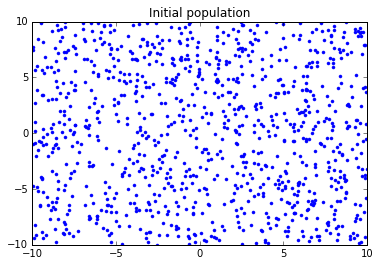

In [60]:
import matplotlib.pyplot as plt
%matplotlib inline

p0 = _initial_population(1000,-10,10,-10,10)
plt.plot(p0[:,0], p0[:,1], '.');
plt.title("Initial population");

## Creating the Next Generation

As mentioned above, the next generation is created from the current generation. First we have the assign a fitness score to all the individuals in the current generation. To score them we will simply plug each point into $f(x,y)$.

Again we can create function that does this for us:

In [61]:
def _score_population(p, f):
    
    # plug every row of p into f
    scores = np.apply_along_axis(f, 1, p)
    scores = scores.reshape(len(scores),1)
    # sort scores
    
    # first append population as last two columns to score
    # matrix will now look like (x,y,score)
    scores = np.append(p, scores, 1)
    
    # sort by last column 
    scores = scores[scores[:,-1].argsort()]
    
    return scores

Let's test this function on the objective function $f(x) = 8x^2 + y^2$.

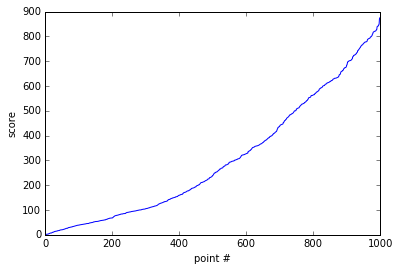

In [62]:
f = lambda x: 8*x[0]**2 + x[1]**2
scores = _score_population(p0, f)
plt.plot(scores[:,2]);
plt.xlabel("point #");
plt.ylabel("score");

## Exercise

Test the initial population function and score function on the objective function $f(x,y) = 16\sin(x)\cos(y)$. Create 500 points on the domain $-1 \leq x,y\leq 1$.

### Elite Children

To generate the next generation, we first find the *elite children*. These children are passed directly to the next generation. These will typically be the best scoring members of the generation. The number of elite children is up to the user, but is typically small, around 2-4. 

In [63]:
def _elite_children(p, n=2):
    
    # take elite children (no score)
    elite = p[0:n,0:-1]
    
    # remove from population
    p = np.delete(p, np.arange(0,n), 0)
    
    return elite, p

In [64]:
elite, scores = _elite_children(scores)
print(elite)
print(scores)

[[-0.24604383 -0.39094853]
 [-0.24654907  0.47085599]]
[[ -4.09342901e-01   3.09315962e-01   1.43616925e+00]
 [ -2.10639188e-01  -1.27566897e+00   1.98228227e+00]
 [  1.54451418e-01   1.41737832e+00   2.19980322e+00]
 ..., 
 [ -9.93607097e+00   7.75957312e+00   8.50015025e+02]
 [  9.90132986e+00  -9.28313025e+00   8.70467171e+02]
 [ -9.91690395e+00  -9.38154009e+00   8.74773167e+02]]


### Selecting Parents

From the remaining population, we have to select a number of parents. Let's call this number $N$. There are many ways to choose these parents. A simple way is choose a random set of $M$ individuals and make the most fit individual from this group a parent. Typically $M$ will be relatively small, for example 4. 

There's no good way to choose $N$, but setting it to be 25% of the total population often works well.

In [7]:
def _select_parents(scores, n = 0.25, M = 4):
    
    # compute number of parents
    N = int(n*len(scores))
    
    parents = []
    for i in range(N):
        
        # create pool of possible parents
        pool = []
        for j in range(M):
            r = np.random.randint(0,len(scores))
            pool.append(scores[r,:])
        
        # sort pool
        pool = np.array(pool)
        pool = pool[pool[:,-1].argsort()]
        
        # add individual with best score
        parents.append(pool[0,:])
        
    return np.array(parents)   

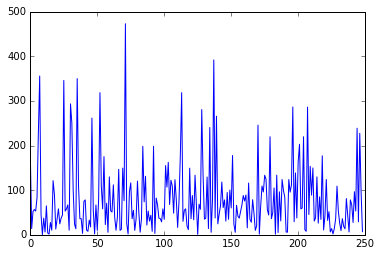

In [8]:
parents = _select_parents(scores)
plt.plot(parents[:,2]);

### Crossover Children

To make crossover children we will take two parents and "combine their genes". What does this mean?

One interpretation (there are others) is to look at the coordinates of the parents as genes. We can create a random binary vector of the same length as the genes and then select genes from parent 1 where the binary vector is 0 and genes from parent 2 where the binary vector is 1.

For example, suppose parent 1 has genes [a, b] and parent 2 has genes [c, d]. The random binary vector [1, 0] would then create the child [c, b]. Note that in this case [0, 0] would create the child [a,b], and [1,1] would create the child [c,d], i.e. the parents are passed directly to the next generation as children. 

In [9]:
def _crossover_children(parents, N):
    
    children = []    
    for i in range(N):
        
        # create random binary vector
        r = np.array([np.random.randint(0,2),np.random.randint(0,2)])
        
        # choose 2 parents
        p1 = parents[np.random.randint(0,len(parents)), 0:2]
        p2 = parents[np.random.randint(0,len(parents)), 0:2]
        
        # get genes
        if r[0] == 0:
            g1 = p1[0]
        else:
            g1 = p2[0]
            
        if r[1] == 0:
            g2 = p1[1]
        else:
            g2 = p2[1]
            
        children.append(np.array([g1,g2]))
        
    return np.array(children)

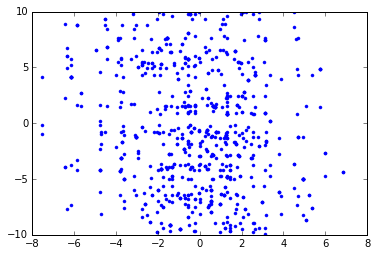

In [10]:
crossover = _crossover_children(parents, 800)
plt.plot(crossover[:,0],crossover[:,1], '.');

### Mutation Children

To make mutation children we will take a random parent and add a normal random number to each gene. The mean of the distribution will be 0 and the standard deviation will depend upon the generation number. Initially we want this standard deviation to be large in order to more fully explore the space, however as we progress we want to decrease the standard deviation. We will use the formula:

$\sigma_k = \sigma_0\left(1 - \frac{k}{G}\right)$
where $G$ is the maximum possible number of generations. Thus when $k = G$ the standard deviation is 0 and there is effectively no mutation.

In [11]:
def _mutation_children(parents, N, k, sigma0 = 2, G = 20):
    
    # compute standard deviation
    sigma = sigma0*(1 - k/G)
    
    children = []
    for i in range(N):
        r = np.random.randint(0,len(parents))
        
        g1 = parents[r,0] + sigma*np.random.randn()
        g2 = parents[r,1] + sigma*np.random.randn()
        
        children.append(np.array([g1,g2]))
        
    return np.array(children)

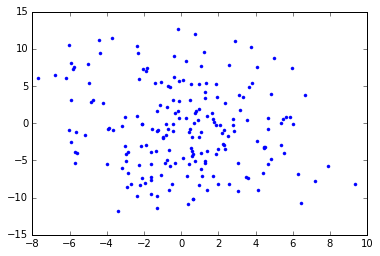

In [12]:
mutations = _mutation_children(parents, 200, 0)
plt.plot(mutations[:,0],mutations[:,1], '.');

## Putting It All Together

In [16]:
def ga(f, xmin, xmax, ymin, ymax, N, Gmax=20):
    
    population = []
    population.append(_initial_population(N, xmin,xmax,ymin,ymax))
    
    for k in range(Gmax):

        scores = _score_population(population[-1], f)
        elites, scores = _elite_children(scores)
        
        parents = _select_parents(scores)
        crossovers = _crossover_children(parents, int(0.8*N))
        mutations = _mutation_children(parents, int(0.2*N), k)
        
        # create next generation
        all_children = np.append(elites, crossovers, 0)
        all_children = np.append(all_children, mutations, 0)
        
        population.append(all_children)
        
    # sort final population by scores, extract best parameters
    scores = _score_population(population[-1], f)
    x_opt = scores[0,:-1]
    
    return population, x_opt

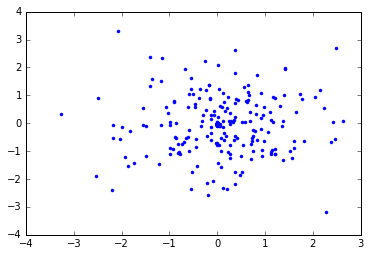

In [36]:
f = lambda x: 8*x[0]**2 + x[1]**2
max_generations = 10
N = 1000
(generations,x_opt) = ga(f, -4, 4, -4, 4, N, max_generations)

plt.plot(generations[-1][:,0], generations[-1][:,1], '.');

## Exercise

Determine how accurate this method is as the number of generations increases. We know that $f(x^*)$ (global minimum) should be 0. Plot $f(x^*)$ as a function of generation number up to generation 30.

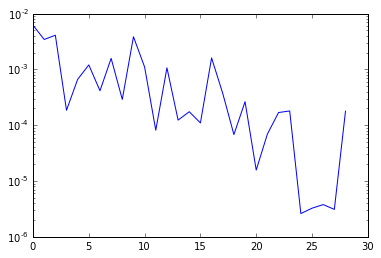

In [39]:
f_opt = []

for i in range(1,30):
    (generations,x_opt) = ga(f, -4, 4, -4, 4, N, i)
    f_opt.append(f(x_opt))
    
plt.semilogy(f_opt)

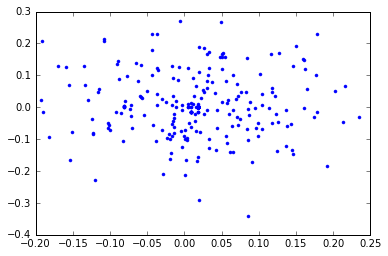

In [15]:
f = lambda x: 20 + x[0]**2 - 20*np.cos(2*np.pi*x[0]) +  x[1]**2 - 20*np.cos(2*np.pi*x[1])
max_generations = 20
N = 1000
generations = ga(f, -4, 4, -4, 4, N, max_generations)

plt.plot(generations[-1][:,0], generations[-1][:,1], '.');

In [ ]:
from matplotlib.animation import FuncAnimation
from matplotlib import rc

# take matplotlib out of inline mode
% matplotlib 
# configure matplotlib animations to display in notebook
rc('animation', html='html5')

# create an empty figure and axis
fig, ax = plt.subplots()

# set axis limits, these will not change during the animation
xmin = -4
xmax = 4
ymin = -4
ymax = 4
ax.set_xlim((xmin,xmax))
ax.set_ylim((ymin,ymax))

# plot f(x,y), this will be on every frame
x = np.linspace(xmin,xmax,1000)
y = np.linspace(ymin,ymax,1000)
X, Y = np.meshgrid(x,y)
plt.contourf(X,Y,f(np.array([X,Y])),50)

# add data set for generations data, we will edit this every frame
population, = ax.plot([],[],'.r')

# at this point since we matplotlib is in inline mode, it prints a blank figure

In [ ]:
# define initialization function
def init():
    population.set_data(generations[0][:,0], generations[0][:,1])

# define update function
def update(k):
    ax.set_title("Generation " + str(k))
    population.set_data(generations[k][:,0], generations[k][:,1])

anim = FuncAnimation(fig, update, init_func=init, frames=range(0,max_generations), interval=500)
anim